In [34]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# 最大表示列数の指定（ここでは50列を指定）
pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 1000)

import warnings
warnings.filterwarnings("ignore")

In [35]:
path = "../input/pickle/"

train = pd.read_pickle(path + "train.zip")

train = train[train["item_category_big"]==6].copy().reset_index(drop=True)

train_x = train.drop(["y"], axis=1)
train_y = train["y"]
test_x = pd.read_pickle(path + "test.zip")

train.drop("item_category_big", axis=1, inplace=True)

test_x = test_x[test_x["item_category_big"]==6].copy()

test_x.drop("item_category_big", axis=1, inplace=True)

In [36]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18184 entries, 0 to 18183
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   18184 non-null  int64  
 1   month                  18184 non-null  int64  
 2   shopID                 18184 non-null  int64  
 3   itemID                 18184 non-null  int64  
 4   item_categoryID        18184 non-null  int64  
 5   item_category_big      18184 non-null  int64  
 6   release_time           18184 non-null  float64
 7   sale_last_month        18184 non-null  float64
 8   item_price_last_month  18184 non-null  float64
 9   item_price_difference  18184 non-null  int64  
 10  item_price             18184 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 1.5 MB


In [37]:
test_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216 entries, 2574 to 3059
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   itemID                 216 non-null    int64  
 1   shopID                 216 non-null    int64  
 2   item_categoryID        216 non-null    int64  
 3   month                  216 non-null    int64  
 4   year                   216 non-null    int64  
 5   release_time           216 non-null    int64  
 6   sale_last_month        216 non-null    float64
 7   item_price_last_month  216 non-null    float64
 8   item_price_difference  216 non-null    float64
 9   item_price             216 non-null    float64
dtypes: float64(4), int64(6)
memory usage: 18.6 KB


In [38]:
train_x.index

RangeIndex(start=0, stop=18184, step=1)

In [39]:
years = [2018] * 6 + [2019] * 9
months = list(range(7, 13)) + list(range(1, 10))

In [40]:
month_list = list(range(1, 7))
year_list = [2017] + [2018]

scores = []

# custom function to run light gbm model
def run_lgb(train_X, train_y, val_X, val_y, x_test):
    params = {"objective" : "regression", 
              "metric" : "rmse", 
              "n_estimators":20000, 
              "early_stopping_rounds":200,
              "num_leaves" : 31, 
              "learning_rate" : 0.01, 
              "bagging_fraction" : 0.7,
              "bagging_seed" : 0, 
              "num_threads" : 4,
              "colsample_bytree" : 0.7,
              'max_depth': 5
             }
    
    lgtrain = lgb.Dataset(tr_x, tr_y)
    lgval = lgb.Dataset(va_x, va_y)
    model = lgb.train(params, lgtrain, 
                      valid_sets=[lgtrain, lgval], 
                      verbose_eval=1000)
    
    pred_test_y = model.predict(x_test, num_iteration=model.best_iteration)
    return pred_test_y, model

for year, month in zip(years, months):
    if year == 2019 and len(year_list) == 2:
        year_list.append(year)
    
    month_list.append(month)
    
    if month == 12:
        year += 1
        month = 1
    
    tr_x = train_x[(train_x["year"].isin(year_list))&(train_x["month"].isin(month_list))]
    va_x = train_x[(train_x["year"] == year)&(train_x["month"] == month)]
    tr_y, va_y = train_y.iloc[tr_x.index], train_y.iloc[va_x.index]
    
    # Training the model
    pred_test, model = run_lgb(tr_x, tr_y, va_x, va_y, test_x)
    
    # バリデーションデータでのスコアの確認
    va_pred = model.predict(va_x)
    score = np.sqrt(mean_squared_error(va_y, va_pred))
    
    scores.append(score)

Training until validation scores don't improve for 200 rounds
[1000]	training's rmse: 1.05985	valid_1's rmse: 0.753387
[2000]	training's rmse: 0.974565	valid_1's rmse: 0.702534
[3000]	training's rmse: 0.913329	valid_1's rmse: 0.668931
[4000]	training's rmse: 0.867563	valid_1's rmse: 0.639868
[5000]	training's rmse: 0.833842	valid_1's rmse: 0.615187
[6000]	training's rmse: 0.804508	valid_1's rmse: 0.590511
[7000]	training's rmse: 0.778247	valid_1's rmse: 0.571599
[8000]	training's rmse: 0.758219	valid_1's rmse: 0.552583
[9000]	training's rmse: 0.735558	valid_1's rmse: 0.535028
[10000]	training's rmse: 0.718162	valid_1's rmse: 0.519831
[11000]	training's rmse: 0.699368	valid_1's rmse: 0.50551
[12000]	training's rmse: 0.683885	valid_1's rmse: 0.496798
[13000]	training's rmse: 0.671608	valid_1's rmse: 0.488705
[14000]	training's rmse: 0.657252	valid_1's rmse: 0.482782
[15000]	training's rmse: 0.644577	valid_1's rmse: 0.473233
[16000]	training's rmse: 0.631762	valid_1's rmse: 0.464981
[1700

In [41]:
scores

[0.4336477659639224,
 0.44185730675817847,
 0.4681337322198307,
 0.9657365970541801,
 0.6145992769337386,
 0.947002162261045,
 0.5836843896879803,
 0.6052402653514498,
 0.7169180501621919,
 0.5788178007329692,
 0.924946133855537,
 0.5157916986629538,
 0.5496330268342893,
 0.5649705746313908,
 0.5729145600838286]

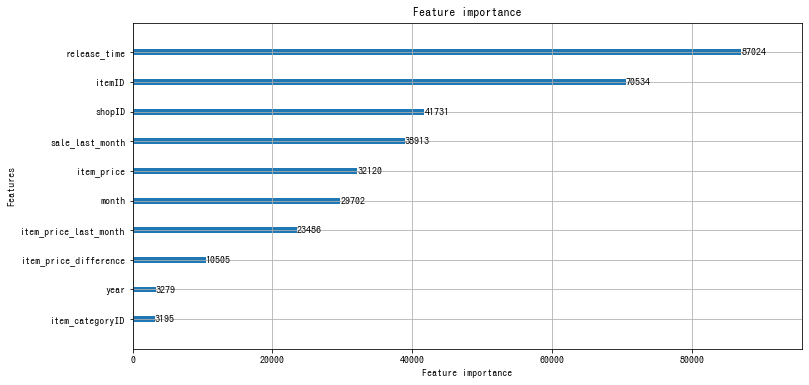

In [42]:
# 特徴量の重要度をプロットする
lgb.plot_importance(model, figsize=(12, 6))
plt.show()

In [43]:
# 予測
test_x["y"] = model.predict(test_x)

In [44]:
test_x.to_pickle('../input/pickle/test_book.zip')

In [45]:
# path = "../submission/"

# submission = pd.read_csv(path + "sample_submission.csv", header=None)

# submission.iloc[:,[1]] = pred
# submission.head()

In [46]:
# submission.to_csv(path + "submission.csv", index=False, header=None)